# UCI Heart Disease Project Proposal for Predicting Heart Disease
#### By: William Chow

## Introduction

Heart diseases are deadly because it can affect the heart and blood vessels which, in turn, could cause heart attacks or strokes. This is why detecting signs of heart disease early is important so it can be treated. Angiography, which is a type of X-ray used to check blood vessels is useful in detecting heart diseases. So, could age, chest pain (cp), cholesterol (chol), resting blood pressure (thalbps), and exercise induced angina (exang) predict the presence of heart disease?

I will be using the Hungarian dataset to predict heart disease. The data set also contains 14 attributes and will be used to predict the presence of heart disease in patients.

## Preliminary exploratory data analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

The data will be downloaded from my public reposity as a raw github `.data` file into the current working directory.

In [2]:
hungarian_data_url <- "https://raw.githubusercontent.com/wchow03/dsci-100-2024s1/main/data/heart_disease/processed.hungarian.data"
download.file(hungarian_data_url, "hungarian_data.data")

In [3]:
disease_cols <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "slope", "oldpeak", "ca", "thal", "num")
hungarian_data <- read_csv("hungarian_data.data", col_names=disease_cols)

head(hungarian_data)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, oldpeak, ca, thal
dbl (5): age, sex, cp, slope, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,oldpeak,ca,thal,num
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
30,0,1,170,237,0,1,170,0,0,?,?,6,0
31,0,2,100,219,0,1,150,0,0,?,?,?,0
32,0,2,105,198,0,0,165,0,0,?,?,?,0


Since all the data types in the data set are doubles from the website, I will convert all the columns to double. I will also replace all "?" with NA so it will not error when running R code.

In [4]:
hungarian_tidydata <- hungarian_data |>
                    mutate(across(everything(), ~ na_if(as.character(.), "?"))) |>
                    mutate(across(everything(), as.numeric))
head(hungarian_tidydata)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,oldpeak,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
28,1,2,130,132,0,2,185,0,0,NA,NA,NA,0
29,1,2,120,243,0,0,160,0,0,NA,NA,NA,0
29,1,2,140,NA,0,0,170,0,0,NA,NA,NA,0
30,0,1,170,237,0,1,170,0,0,NA,NA,6,0
31,0,2,100,219,0,1,150,0,0,NA,NA,NA,0
32,0,2,105,198,0,0,165,0,0,NA,NA,NA,0


The data will be split into 70% in the training set and 30% in the testing set.

In [5]:
hungarian_filtered <- hungarian_tidydata |>
                        select(age:chol, exang, num)
hungarian_split <- initial_split(hungarian_filtered, prop=0.7, strata=num)
hungarian_train <- training(hungarian_split)
hungarian_test <- testing(hungarian_split)

Below is a dataframe summarizing the means of each predictor variable is in the training set.

In [6]:
hungarian_train |>
    map_df(mean, na.rm=TRUE)

age,sex,cp,trestbps,chol,exang,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
47.96585,0.7365854,3.014634,132.6471,251.3777,0.3088235,0.3609756


Next I will create histograms and bar plots to examine the distribution of the predictor variables.

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 17 rows containing non-finite outside the scale range (`stat_bin()`).”


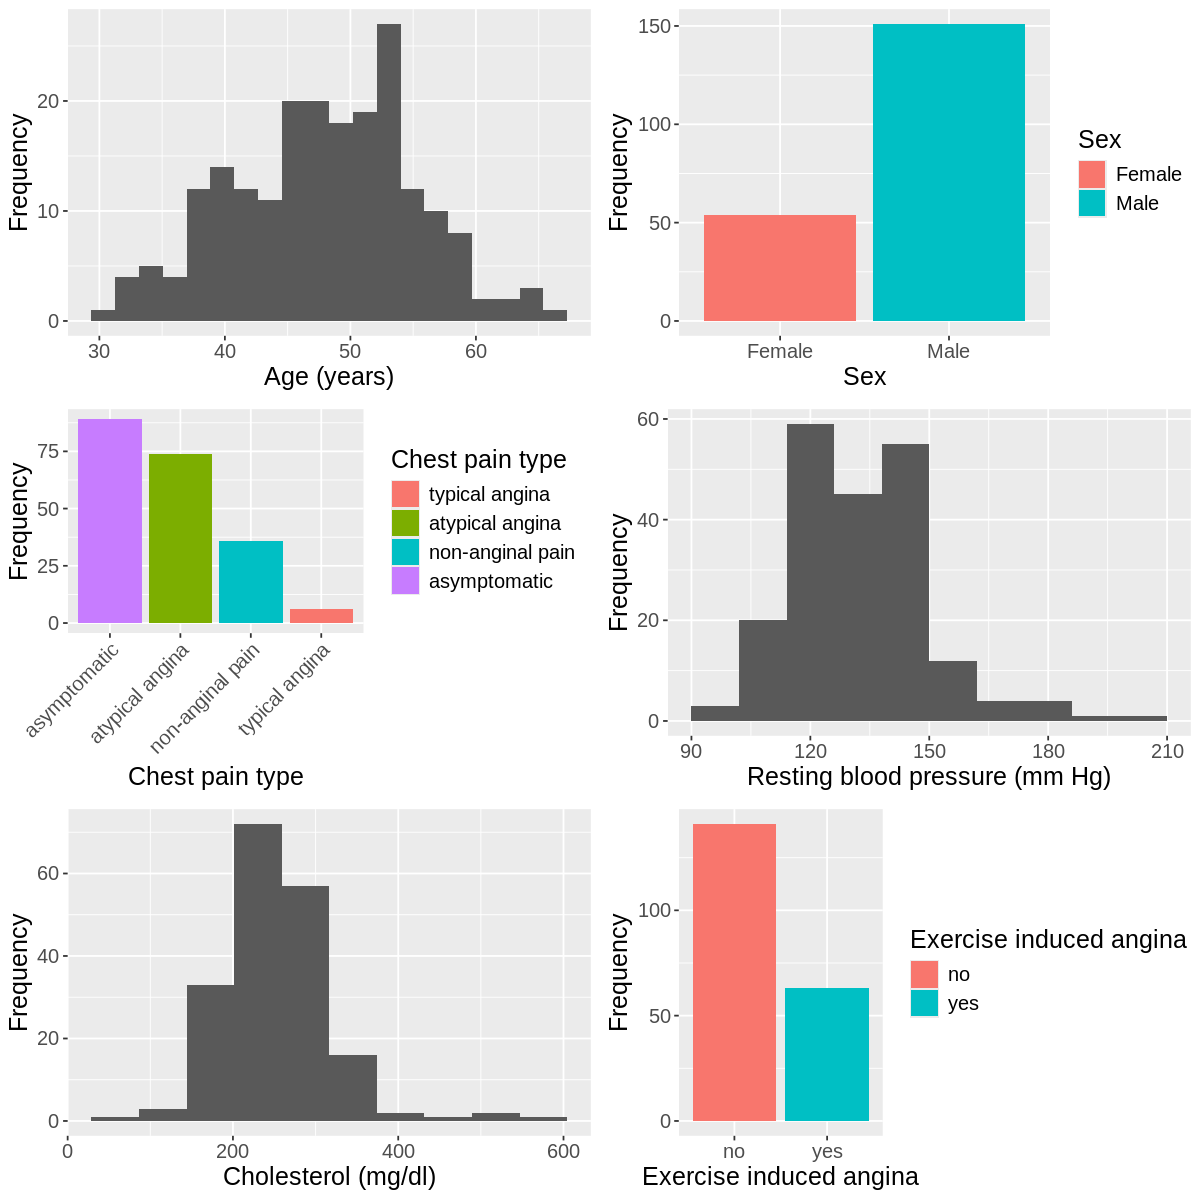

In [7]:
options(repr.plot.width=10, repr.plot.height=10)
age_plot <- ggplot(hungarian_train, aes(x=age)) +
                geom_histogram(bins=20) +
                labs(x="Age (years)", y="Frequency") +
                theme(text=element_text(size=15))
# Code for mutate referenced here: https://stackoverflow.com/questions/48571773/how-do-i-replace-multiple-character-strings-in-a-column-to-numbers
sex_column <- hungarian_train |>
                select(sex) |>
                mutate(sex_str=case_when(sex==0 ~ "Female", sex==1 ~ "Male"))

sex_plot <- ggplot(sex_column, aes(x=sex_str, fill=as_factor(sex_str))) +
                geom_bar() +
                labs(x="Sex", y="Frequency", fill="Sex") +
                theme(text=element_text(size=15))

cp_column <- hungarian_train |>
                select(cp) |>
                mutate(cp_str=case_when(cp==1 ~ "typical angina", cp==2 ~ "atypical angina", cp==3 ~ "non-anginal pain", cp==4 ~ "asymptomatic"))

cp_plot <- ggplot(cp_column, aes(x=cp_str, fill=as_factor(cp_str))) +
            geom_bar() +
            labs(x="Chest pain type", y="Frequency", fill="Chest pain type") +
            theme(text=element_text(size=15), axis.text.x = element_text(angle=45, hjust=1))

trestbps_plot <- ggplot(hungarian_train, aes(x=trestbps)) +
                geom_histogram(bins=10) +
                labs(x="Resting blood pressure (mm Hg)", y="Frequency") +
                theme(text=element_text(size=15))

chol_plot <- ggplot(hungarian_train, aes(x=chol)) +
                geom_histogram(bins=10) +
                labs(x="Cholesterol (mg/dl)", y="Frequency") +
                theme(text=element_text(size=15))

exang_column <- hungarian_train |>
                select(exang) |>
                mutate(exang_str=case_when(exang==0 ~ "no", exang==1 ~ "yes")) |>
                filter(exang != "NA")

exang_plot <- ggplot(exang_column, aes(x=exang_str, fill=as_factor(exang_str))) +
            geom_bar() +
            labs(x="Exercise induced angina", y="Frequency", fill="Exercise induced angina") +
            theme(text=element_text(size=15))

plot_grid(age_plot, sex_plot, cp_plot, trestbps_plot, chol_plot, exang_plot, nrow=3, ncol=2)

## Methods

I will use age, sex, chest pain type (cp), resting blood pressure (trestbps), cholesterol (chol), and exercise induced angina (exang) as predictors to predict the presence of heart disease. If heart disease is present then it will symbolize a $1$, if heart disease is not present then it will symbolize as a $0$.

I will use a confusion matrix to display the results to see how well the accuracy, precision, and recall perform on the trained model.

## Expected outcomes and significance

I expect to find that the predictors I have chosen will be good predictors of predicting if heart disease is present or not through a confusion matrix.

If the model is able to reliably predict if heart disease is present or not then it could be useful in detecting early signs of heart disease so it could be treated properly.

Which of the predictor variables are the most significant in predicting heart disease?

Could the presence of heart disease be predicted with fewer variables than I have proposed? If so, then it could mean that we need to collect less data about patients to figure out if heart disease is present or not.

